In [148]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import DataFrame
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,f1_score
from sklearn.model_selection import GridSearchCV, KFold,cross_val_score, RandomizedSearchCV,train_test_split
from sklearn import metrics
from xgboost import XGBClassifier
import xgboost as xgb
from scipy.stats import uniform, randint
from sklearn.metrics import ConfusionMatrixDisplay

SEED = 2023

In [149]:
%run "datasets/parse.ipynb"
train_df = parse_train("")
test_df = parse_test("")

In [150]:
categorical_to_numerical = {
    'Injecao na rede (kWh)': {
        'None': 0,
        'Low': 1,
        'Medium': 2,
        'High':3,
        'Very High':4
    },
    'weather_description': {
        'overcast clouds': 0,
        'scattered clouds': 1,
        'few clouds': 2,
        'sky is clear': 3,
        'broken clouds': 4,
        'light rain': 5,
        'moderate rain': 6,
        'heavy intensity rain':7
    }
}

numeric_columns = ['Hora', 'Normal (kWh)', 'Horario Economico (kWh)', 'Autoconsumo (kWh)', 'temp','feels_like','temp_min','temp_max','pressure','humidity', 'wind_speed','clouds_all','rain_1h']


In [151]:
def xgboost_data_preparation(df: DataFrame,test_or_train) -> DataFrame:

    prep_df= df
    prep_df['rain_1h'] = prep_df['rain_1h'].replace('', '0')
    prep_df['rain_1h'] = pd.to_numeric(prep_df['rain_1h'])
            
    ### Converter as features categoricas em numericas
    prep_df.replace(categorical_to_numerical, inplace=True)

    ### Extrair a hora e dia da semana da feature 'record_date'
    record_date = pd.DatetimeIndex(prep_df['Data'])

    prep_df['Month'] = record_date.month
    prep_df['Day'] = record_date.day
    prep_df['Year'] = record_date.year

    dropped_columns = ['grnd_level','sea_level','dt','Data','city_name']
    prep_df = prep_df.drop(dropped_columns, axis=1)

    prep_df.loc[(prep_df['Hora'] < 6) & (prep_df['Hora'] > 21), 'Injecao na rede (kWh)'] = 0

    

   
    ### Limites superior e inferior (sem outliers) dos diagramas de caixa
    whiskers = []
    for num in numeric_columns:
        Q1 = prep_df[num].quantile(0.25)
        Q3 = prep_df[num].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        whiskers.append((num,lower,upper))

    ### Tratar os outliers das features numéricas:
    ### Substituir os valores dos outliers pela mediana
    if(train_test_split == "train"):
        for num, lower, upper in whiskers:
            prep_df = prep_df[(prep_df[num] >= lower) & (prep_df[num] <= upper)]

    return prep_df

In [152]:
prep_df = xgboost_data_preparation(train_df,"train")

X = prep_df

# Separate the target variable from the input features
y = X['Injecao na rede (kWh)']
X.drop(columns=['Injecao na rede (kWh)'], inplace=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [153]:
params = {
    "colsample_bytree": uniform(0.7, 0.3)
    ,"gamma": uniform(0, 0.5)
    ,"learning_rate": uniform(0.1, 0.3) # default 0.1 
    ,"max_depth": randint(2, 6) # default 3
    ,"n_estimators": randint(100, 1000) # default 100
    ,"subsample": uniform(0.6, 0.4)
}
kf = KFold(n_splits=5,shuffle=True,random_state=25112002)

model= XGBClassifier(random_state=25112002,n_estimators=200,max_depth=100)

search = RandomizedSearchCV(model, param_distributions=params, random_state=42, cv=3, verbose=2, n_jobs=1, return_train_score=True)

search.fit(X_train,np.ravel(y_train))

prediction =search.best_estimator_.predict(X_test)
print(classification_report(y_test,prediction))
print('Accuracy',metrics.accuracy_score(y_test,prediction))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.8123620356542087, gamma=0.4753571532049581, learning_rate=0.31959818254342154, max_depth=2, n_estimators=120, subsample=0.6624074561769746; total time=   0.2s
[CV] END colsample_bytree=0.8123620356542087, gamma=0.4753571532049581, learning_rate=0.31959818254342154, max_depth=2, n_estimators=120, subsample=0.6624074561769746; total time=   0.2s
[CV] END colsample_bytree=0.8123620356542087, gamma=0.4753571532049581, learning_rate=0.31959818254342154, max_depth=2, n_estimators=120, subsample=0.6624074561769746; total time=   0.2s
[CV] END colsample_bytree=0.7467983561008608, gamma=0.02904180608409973, learning_rate=0.3598528437324805, max_depth=5, n_estimators=971, subsample=0.8832290311184181; total time=   2.9s
[CV] END colsample_bytree=0.7467983561008608, gamma=0.02904180608409973, learning_rate=0.3598528437324805, max_depth=5, n_estimators=971, subsample=0.8832290311184181; total time=   2.9s
[CV]

In [154]:
print(f1_score(y_test,prediction, average='macro'))
print(f1_score(y_test,prediction, average='micro'))
print(f1_score(y_test,prediction, average='weighted'))


0.6179145243335481
0.8628318584070797
0.8661364921124449


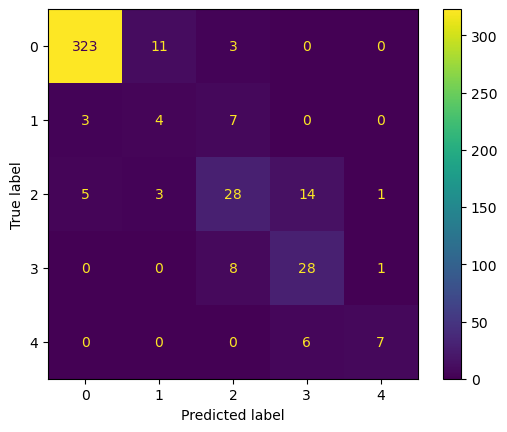

In [155]:
ConfusionMatrixDisplay.from_predictions(y_test,prediction)

In [156]:
predict = xgboost_data_preparation(test_df,"test").drop('Injecao na rede (kWh)',axis=1)

predictions = search.best_estimator_.predict(predict)

predictions_df = pd.DataFrame(predictions)

numerical_to_categorical = {
    0: {
        0 : 'None',
        1 : 'Low',
        2 : 'Medium',
        3 : 'High',
        4 : 'Very High'
    }
}

predictions_df.replace(numerical_to_categorical, inplace=True)

predictions_df.index += 1

predictions_df.to_csv("submission.csv", header=['Result'], index_label='RowId')